# Accuracy

In this notebook we will look at the impact on accuracy of a model when we use imbalanced data. We will compare different algorithms and how they behave on different datasets
***

In [51]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

[We already know](https://dsgissin.github.io/DiscriminativeActiveLearning/) that active learning algorithms can drastically reduce the amount of samples needed to be labeled in order to obtain good accuracy. We will now look at the accuracy when we use imbalanced data.

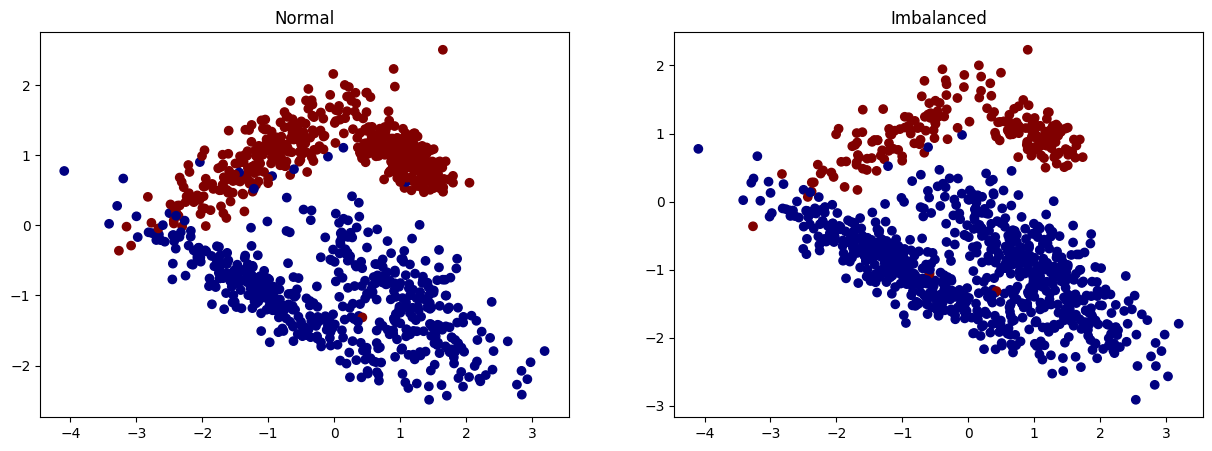

In [74]:
## generate classifier problems ##
X_nrml, y_t_nrml = make_classification(n_samples=1000, n_features=2, n_redundant=0, random_state=100000)
X_imbalanced, y_t_imbalanced = make_classification(n_samples=1000, n_features=2, n_redundant=0, weights=[0.8, 0.2], random_state=100000)

# plot the classifier problems
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

axs[0].scatter(X_nrml[:,0], X_nrml[:,1], c=y_t_nrml, cmap='jet')
axs[0].set_title('Normal')

axs[1].scatter(X_imbalanced[:,0], X_imbalanced[:,1], c=y_t_imbalanced, cmap='jet')
axs[1].set_title('Imbalanced')

fig.show()

As we can see the imbalanced data set has very few red samples. First of all we will look at how a normal classifier will handle this data.

In [109]:
def get_accuracy(qs_type, weights=None, cycles=30):
    data = []
    for rand in range(100):
        qs = qs_type(random_state=rand)
        X, y_true = make_classification(n_samples=100, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

        clf.fit(X, y)
        for _ in range(cycles):
            i = qs.query(X, y) if type(qs) == RandomSampling else qs.query(X, y, clf)
            y[i] = y_true[i]
            clf.fit(X,y)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)



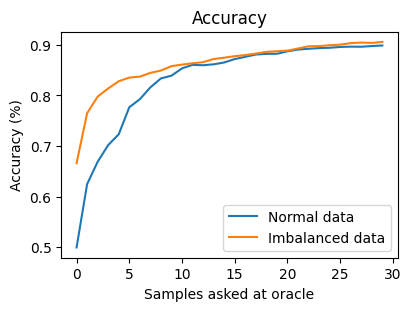

In [112]:
acc_nrml = get_accuracy(RandomSampling)
acc_imbalanced= get_accuracy(RandomSampling, weights=[0.8, 0.2])
 

# plot 
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
c = np.arange(30)
ax.plot(c, acc_nrml, label='Normal data')
ax.plot(c, acc_imbalanced, label='Imbalanced data')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Samples asked at oracle')
ax.set_title('Accuracy')
ax.legend()
fig.show()

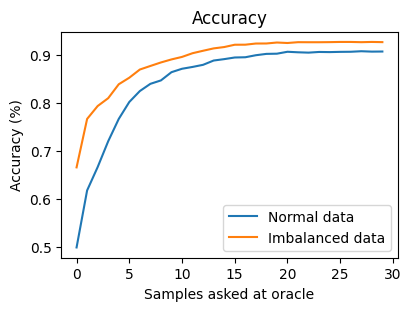

In [111]:
acc_nrml = get_accuracy(UncertaintySampling)
acc_imbalanced= get_accuracy(UncertaintySampling, weights=[0.8, 0.2])
 

# plot 
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
c = np.arange(30)
ax.plot(c, acc_nrml, label='Normal data')
ax.plot(c, acc_imbalanced, label='Imbalanced data')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Samples asked at oracle')
ax.set_title('Accuracy')
ax.legend()
fig.show()